In [9]:
import numpy as np
import gensim, logging
import csv, string
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
import pandas as pd
import tensorflow as tf
import os
import pickle

num_words = 100
num_words_description = 100
directory_prefix = "../"
label_depth = 4
import random
#import gensim.downloader as api
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import remove_stopwords

#wv = api.load("glove-wiki-gigaword-50")

porter = PorterStemmer()

import tensorflow_hub as hub

#embed = hub.load("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1")
embed = hub.load("https://tfhub.dev/google/Wiki-words-500/2")

embeddings = embed(["cat is on the mat", "dog is in the fog"])
embedding_dim = embeddings.shape[1]
print(embeddings)
def get_sentence_vector(words, num_words):
    #print(words)
    words = word_tokenize(remove_stopwords(words))
    ret = embed(words)
    #print(ret)
    ret = tf.math.reduce_mean(ret, axis=0)
    return ret
 
with open(directory_prefix+"/class_descriptions/class_descriptions_from_patents.pickle", 'rb') as f:
    label_dict = pickle.load(f)
label_dict = {k[:label_depth]: get_sentence_vector(val.lower(), num_words_description) for k, val in label_dict.items()}
#label_dict = {k[:label_depth]: get_sentence_vector(val.lower(), num_words_description) for k, val in label_dict.items()}

label_dict_keys = set(label_dict.keys())


tf.Tensor(
[[-6.86858501e-03 -3.76424156e-02  4.62400503e-02 -1.23278514e-01
   2.71930415e-02 -7.59339556e-02 -4.28200960e-02 -7.85721466e-02
   1.66612249e-02  9.40367877e-02 -4.30155955e-02  6.53031692e-02
   3.68250650e-03 -5.39891236e-02  6.64428324e-02  2.66480502e-02
  -8.13730881e-02  6.45384565e-02  5.24570420e-02 -1.06043547e-01
   6.34610876e-02 -3.33643258e-02  8.36845711e-02  7.18151638e-03
   7.24382624e-02  1.88112520e-02  2.50422806e-02 -1.92195643e-02
   4.32674177e-02 -5.09084649e-02  8.73182639e-02 -1.69842660e-01
  -1.67683419e-02 -1.57154173e-01  2.44784605e-04  3.62398438e-02
   6.18532784e-02 -1.87336206e-02  2.05009673e-02  2.28712931e-02
  -8.07850584e-02 -3.92899737e-02 -1.04598075e-01  2.22915281e-02
   6.01249300e-02  3.74532565e-02 -5.11096008e-02 -9.43856165e-02
   3.02176457e-02 -4.07137163e-02  2.60221884e-02  1.24136731e-01
  -1.34881930e-02  8.28350484e-02  4.55747321e-02  3.50643210e-02
  -3.73812132e-02  7.28645697e-02 -1.62608009e-02  7.31788226e-04

In [2]:
print(label_dict_keys)

{'G01H', 'C10H', 'D06C', 'D03J', 'A41C', 'H02G', 'F41B', 'B04B', 'B42D', 'B63H', 'C10J', 'B21K', 'B23F', 'B33Y', 'G01L', 'A61P', 'F26B', 'A01H', 'C06B', 'C05B', 'C01D', 'C13K', 'H01F', 'C12Q', 'H01B', 'B04C', 'A24D', 'H01R', 'G21F', 'F02P', 'B23K', 'B82Y', 'G05G', 'A21C', 'F41A', 'A01F', 'D04B', 'A47K', 'F03D', 'E05F', 'F16N', 'G99Z', 'D05B', 'B27B', 'B65F', 'A01L', 'D05C', 'F21L', 'C09F', 'A47G', 'B02C', 'B25J', 'B64G', 'D06F', 'A23J', 'B60H', 'C08B', 'A01C', 'H04H', 'F24H', 'G21C', 'G01N', 'A23F', 'C12J', 'A21D', 'F02G', 'G04B', 'G09F', 'F16P', 'B27F', 'B64B', 'B67B', 'B60M', 'A23G', 'H01C', 'B07C', 'C07G', 'B65C', 'C22B', 'B27K', 'C99Z', 'F24S', 'B60J', 'F22D', 'B27D', 'A41G', 'B05C', 'G04G', 'G16H', 'F23Q', 'A23L', 'A21B', 'G21G', 'A99Z', 'F16D', 'C21D', 'B41C', 'B66D', 'G04C', 'A24B', 'C23F', 'D06J', 'A23N', 'F16G', 'C12M', 'B43M', 'A47F', 'C12Y', 'G05D', 'A63H', 'F16F', 'F41C', 'B65B', 'B21H', 'E21F', 'F04D', 'D21G', 'G03G', 'B27C', 'C07K', 'C23C', 'Y02C', 'Y10T', 'C12P', 'B63B',

In [20]:
def lstm_data_generator():
    current_dataframe = pd.read_csv(directory_prefix+'datasets/dataset2002-2020.csv',sep=',', header = None).to_numpy()#, chunksize=100000)
    indices = np.random.choice(len(current_dataframe), len(current_dataframe)-1)
    #indices = np.random.choice(len(current_dataframe), len(current_dataframe)//2)
    for row in current_dataframe[indices]:
        label, description=row[0], str(row[1])+str(row[2])
        lstm_input_patent = get_sentence_vector(description.lower(), num_words)
        #lstm_input_patent = get_sentence_vector(description.lower(), num_words)

        label_vectors = [z.strip().strip('\'\"')[:label_depth] for z in label.split(',')]
        label_vectors = set([i for i in label_vectors if i in label_dict_keys])
        non_true_vectors = [label_dict[i] for i in random.sample(label_dict_keys, min(len(label_vectors), len(label_dict.keys()))) if i not in label_vectors]
        for l in (label_dict[i] for i in label_vectors):
            yield ({'input_1':lstm_input_patent, 'input_2':l}, {'output_binary':[1]})

        for l in non_true_vectors:
            yield ({'input_1':lstm_input_patent, 'input_2':l}, {'output_binary':[0]})

lstm_dataset = tf.data.Dataset.from_generator(lstm_data_generator, ({'input_1':tf.float64, 'input_2':tf.float64}, {'output_binary':tf.float64}), ({'input_1':tf.TensorShape([embedding_dim]), 'input_2':tf.TensorShape([embedding_dim])}, {'output_binary':tf.TensorShape([1])}))
lstm_dataset = lstm_dataset.batch(64, drop_remainder=True).repeat().prefetch(100)

In [ ]:
for i in lstm_dataset:
    print(i)
    break

In [4]:
input_patent = tf.keras.Input(shape=(embedding_dim,), name='input_1')
input_label = tf.keras.Input(shape=(embedding_dim,), name='input_2')

layer_size = 2000

patent = tf.keras.layers.Dense(layer_size)(input_patent)
label =  tf.keras.layers.Dense(layer_size)(input_label)

subtract = tf.keras.layers.Subtract()([patent, label])
multiply = tf.keras.layers.Multiply()([patent, label])

concat = tf.keras.layers.Concatenate(axis=1)([label, patent, subtract, multiply])
dense = tf.keras.layers.Dense(int(layer_size))(concat)
dense = tf.keras.layers.Dense(int(layer_size))(dense)
dense = tf.keras.layers.Dropout(.2)(dense)
dense = tf.keras.layers.Dense(int(layer_size*4), activation='relu')(dense)

output_binary = tf.keras.layers.Dense(1, name='output_binary')(dense)


#lstm_enforce_1 = tf.keras.layers.Dense(200, activation='relu')(patent_lstm)
#lstm_enforce_2 = tf.keras.layers.Dense(1000, name='output_2')(lstm_enforce_1)
#model = tf.keras.Model(inputs={'input_1':input_lstm, 'input_2':input_label}, outputs={'output_1':output_binary, 'output_2':lstm_enforce_2})
model = tf.keras.Model(inputs={'input_1':input_patent, 'input_2':input_label}, outputs=[output_binary])
print(model)


In [5]:
#saver = tf.train.Saver(max_to_keep=4, keep_checkpoint_every_n_hours=2)
#del model
try:
    #model.load_weights(directory_prefix+"/nonLSTMCheckpoint.h5")
    pass
except:
    pass
model.summary()
opt = tf.optimizers.Adam(learning_rate=0.0003)
model.compile(loss=['mse'],
              optimizer=opt,
              metrics=['accuracy'], experimental_run_tf_function=False)


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=directory_prefix+"/nonLSTMCheckpoint.h5",
                                                 save_weights_only=False,
                                                 verbose=1)

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        generate_prc(1000)
prc_callback = CustomCallback()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2000)         1002000     input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 2000)         1002000     input_1[0][0]                    
_______________________________________________________________________________________

In [6]:
current_dataframe = pd.read_csv(directory_prefix+'/datasets/claims_dataset_1.csv',sep=',', header = None).to_numpy()#, chunksize=100000)
#indices = np.random.choice(300000, 10000)
occurences={k:0 for k in label_dict_keys}
for row in current_dataframe:
    label, description=row[0], row[1]
    label_vectors = [z.strip().strip('\'\"')[:label_depth] for z in label.split(',')]
    label_vectors = set([i for i in label_vectors if i in label_dict_keys])
    for i in label_vectors:
        occurences[i] += 1
print(occurences)

{'G01H': 163, 'C10H': 0, 'D06C': 16, 'D03J': 7, 'A41C': 65, 'H02G': 250, 'F41B': 91, 'B04B': 87, 'B42D': 130, 'B63H': 195, 'C10J': 67, 'B21K': 70, 'B23F': 36, 'B33Y': 976, 'G01L': 619, 'A61P': 2187, 'F26B': 220, 'A01H': 1105, 'C06B': 39, 'C05B': 43, 'C01D': 37, 'C13K': 38, 'H01F': 391, 'C12Q': 1631, 'H01B': 387, 'B04C': 65, 'A24D': 60, 'H01R': 534, 'G21F': 58, 'F02P': 138, 'B23K': 1024, 'B82Y': 480, 'G05G': 149, 'A21C': 37, 'F41A': 268, 'A01F': 103, 'D04B': 86, 'A47K': 311, 'F03D': 312, 'E05F': 277, 'F16N': 97, 'G99Z': 0, 'D05B': 67, 'B27B': 81, 'B65F': 109, 'A01L': 8, 'D05C': 33, 'F21L': 98, 'C09F': 6, 'A47G': 437, 'B02C': 230, 'B25J': 926, 'B64G': 160, 'D06F': 294, 'A23J': 36, 'B60H': 380, 'C08B': 195, 'A01C': 186, 'H04H': 41, 'F24H': 148, 'G21C': 37, 'G01N': 5186, 'A23F': 55, 'C12J': 2, 'A21D': 60, 'F02G': 45, 'G04B': 92, 'G09F': 382, 'F16P': 40, 'B27F': 33, 'B64B': 16, 'B67B': 44, 'B60M': 37, 'A23G': 129, 'H01C': 38, 'B07C': 87, 'C07G': 10, 'B65C': 68, 'C22B': 155, 'B27K': 17, 'C99

['G06F', 'A61B', 'A61K', 'G01N', 'G02B', 'H01L', 'H04L', 'C12N', 'A61M', 'A61F', 'G06T', 'B29C', 'H04N', 'G06K', 'G06Q', 'B01D', 'Y10T', 'C07K', 'B32B', 'C07D', 'A61P', 'G02F', 'G05B', 'E21B', 'C08L', 'G01R', 'F21V', 'B01J', 'B65D', 'G05D', 'B60R', 'G01S', 'C12Q', 'C07C', 'F05D', 'B60K', 'G09G', 'C08K', 'F01D', 'G06N', 'B62D', 'C08G', 'A61N', 'F16H', 'Y02T', 'A61L', 'H04W', 'G01C', 'C09D', 'B60W', 'H05K', 'C08F', 'B41J', 'B29K', 'B64C', 'C09K', 'C08J', 'B64D', 'C23C', 'A01H', 'B29L', 'A63B', 'G03G', 'B23K', 'F16K', 'G01B', 'F16L', 'H01M', 'B33Y', 'Y02P', 'G16H', 'F04D', 'B25J', 'F02C', 'G03B', 'B65G', 'F16B', 'H02J', 'G11C', 'C02F', 'F02D', 'C01B', 'H05B', 'C12P', 'Y02E', 'F21Y', 'F21S', 'A63F', 'G03F', 'B60L', 'F16C', 'H04B', 'A01N', 'G08B', 'F02M', 'B01L', 'G01V', 'G08G', 'F02B', 'A61Q', 'C12Y', 'A23L', 'G01M', 'Y10S', 'F24F', 'F16D', 'A01K', 'B60Q', 'B60N', 'C22C', 'B05B', 'B65H', 'F25B', 'Y02A', 'C04B', 'G01F', 'G01J', 'G01L', 'C07H', 'H04M', 'F01N', 'G01D', 'B01F', 'B65B', 'F04B',

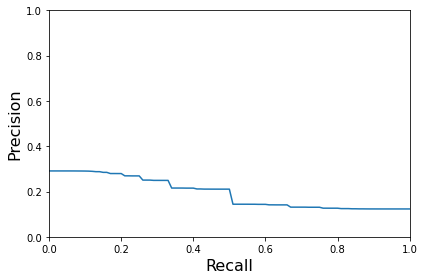

In [7]:
n = 0
d=0
recalls = np.arange(0, 1.01, .01)
ns = []
prediction = sorted(occurences.keys(), key=lambda x: occurences[x])[::-1]
print(prediction)
occurences = {k: 0 for k in label_dict_keys}
for row in pd.read_csv(directory_prefix+'datasets/claims_dataset_1.csv',sep=',', header = None).to_numpy():
    label, description=row[0], row[2]
    label_vectors = [z.strip().strip('\'\"')[:label_depth] for z in label.split(',')]
    label_vectors = set([i for i in label_vectors if i in label_dict_keys])
    if label_vectors == set():
        continue
    #if(sum([occurences[i] for i in label_vectors]) >= len(label_vectors)):
    #    continue
    for i in label_vectors:
        occurences[i] += 1
    e = [1 if i in label_vectors else 0 for i in prediction]
    cur = []
    total_ones = e.count(1)
    n = 0
    ones_seen = 0
    while ones_seen < total_ones:
        if e[n] == 1:
            ones_seen = ones_seen+1
        n = n+1
        cur.append((ones_seen/float(n), ones_seen/float(total_ones)))
    new_cur = []
    for r in recalls:
        max_of_larger = max([i[0] for i in cur if i[1] >= r])
        new_cur.append(max_of_larger)
    ns.append(new_cur)

p_baseline = np.mean(np.array(ns), axis=0)
import matplotlib.pyplot as plt
plt.plot(recalls, p_baseline)
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.margins(0.1)
#plt.xticks(range(len(distribution_dict.keys()))[::50], new_x[::50], rotation='vertical')
plt.ylabel('Precision', fontsize=16)
plt.xlabel('Recall', fontsize=16)
plt.tight_layout()
plt.show()

In [18]:


def generate_prc(num_tests):
    label_len = len(label_dict_keys)
    #print(label_len)
    left = [label_dict[i] for i in label_dict_keys]
    predictions = []
    left_vectors = np.array(list(label_dict_keys))
    label_vectors_vector = []
    occurences = {k: 0 for k in label_dict_keys}
    def cur_gen():
        current_dataframe = pd.read_csv(directory_prefix+'datasets/claims_dataset_1.csv',sep=',', header = None).to_numpy()#, chunksize=100000)
        indices = np.random.choice(len(current_dataframe), len(current_dataframe)-1)
        for row in current_dataframe[indices]:
            label, description=row[0], row[1]+row[2]
            label_vectors = [z.strip().strip('\'\"')[:label_depth] for z in label.split(',')]
            label_vectors = set([i for i in label_vectors if i in label_dict_keys])
            if label_vectors == set():
                continue
            #if(sum([occurences[i] for i in label_vectors]) >= len(label_vectors)):
            #    continue
            #for i in label_vectors:
            #    occurences[i] += 1
            label_vectors_vector.append(label_vectors)
            lstm_input_patent = get_sentence_vector(description.lower(), num_words)
            for i in left:
                yield ({'input_1':lstm_input_patent, 'input_2':i})
    dataset = tf.data.Dataset.from_generator(cur_gen, ({'input_1':tf.float64, 'input_2':tf.float64}), ({'input_1':tf.TensorShape([embedding_dim]), 'input_2':tf.TensorShape([embedding_dim])}))
    dataset = dataset.batch(label_len).prefetch(50)
    predictions = model.predict(dataset, steps=num_tests, verbose=1).reshape(num_tests, label_len)
    #print(occurences)
    n = 0
    d=0
    ns = []
    recalls = np.arange(0, 1.01, .01)
    ns = []
    for prediction, label_vectors in zip(predictions, label_vectors_vector):
        indices = np.flip(np.argsort(prediction, axis=0))
        #print(left_vectors[indices])
        e = [1 if i in label_vectors else 0 for i in left_vectors[indices]]
        cur = []
        total_ones = e.count(1)
        n = 0
        ones_seen = 0
        while ones_seen < total_ones:
            if e[n] == 1:
                ones_seen = ones_seen+1
            n = n+1
            cur.append((ones_seen/float(n), ones_seen/float(total_ones)))
        new_cur = []
        for r in recalls:
            max_of_larger = max([i[0] for i in cur if i[1] >= r])
            new_cur.append(max_of_larger)
        ns.append(new_cur)
        #print(max(new_cur))
        d = d+1
        #print(float(d)/7215)
        #print(np.mean(np.vstack(ns), axis=0)[0])
    p = np.mean(np.array(ns), axis=0)
    np.save("newest_ps.npy", p)
    np.save("predictions.npy", predictions)
    np.save("label_vectors_vector.npy", label_vectors_vector)
    import matplotlib.pyplot as plt
    plt.plot(recalls, p)
    plt.plot(recalls, p_baseline, 'r')
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.margins(0.1)
    #plt.xticks(range(len(distribution_dict.keys()))[::50], new_x[::50], rotation='vertical')
    plt.ylabel('Precision', fontsize=16)
    plt.xlabel('Recall', fontsize=16)
    plt.tight_layout()
    plt.show()
    print(p) 
    plt.savefig('binary_prc1.eps', format='eps')

Epoch 1/100
1000/1000 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.9254
Epoch 00001: saving model to ../nonLSTMCheckpoint.h5
1000/1000 [==============================] - 102s 102ms/step


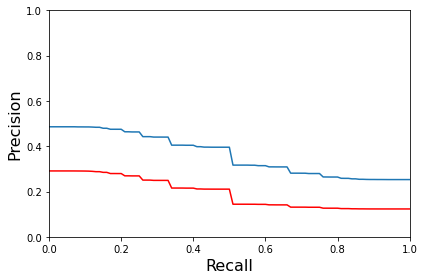

[0.48594359 0.48594359 0.48594359 0.48594359 0.48594359 0.48594359
 0.48594359 0.48594359 0.48544359 0.48544359 0.48530073 0.48530073
 0.4846674  0.48375629 0.48375629 0.47943463 0.47943463 0.47499795
 0.47499795 0.4749535  0.4749535  0.46384184 0.46384184 0.46316171
 0.46316171 0.46316171 0.44237392 0.44237392 0.44237392 0.44048424
 0.44048424 0.44048424 0.44040488 0.44040488 0.40475263 0.40475263
 0.40475263 0.40475263 0.40433824 0.40433824 0.40433824 0.39804564
 0.39804564 0.39609011 0.39609011 0.39573761 0.39569625 0.39569625
 0.39569625 0.39569625 0.39569625 0.31664208 0.31664208 0.31664208
 0.31664208 0.31663064 0.31621014 0.31621014 0.31419605 0.31419605
 0.31419605 0.30888757 0.30888757 0.30869389 0.30867079 0.30867079
 0.30867079 0.28103787 0.28103787 0.28103787 0.2808804  0.2808804
 0.27946007 0.27946007 0.27946007 0.27946007 0.26434758 0.26420592
 0.26398763 0.26398763 0.26398763 0.25842726 0.25819023 0.25819023
 0.25599339 0.25598506 0.2540172  0.2540172  0.25342144 0.25314

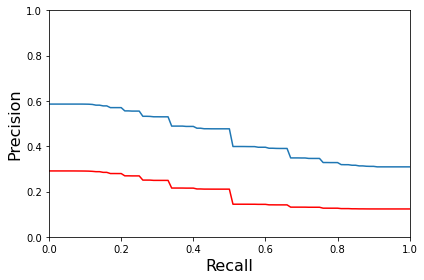

[0.5861932  0.5861932  0.5861932  0.5861932  0.5861932  0.5861932
 0.5861932  0.5861932  0.5861932  0.5861932  0.5859932  0.58565987
 0.58464796 0.58144342 0.58144342 0.57822746 0.57822746 0.57058413
 0.57058413 0.57058413 0.57058413 0.55612365 0.55612365 0.55525881
 0.55525881 0.55525881 0.53227788 0.53227788 0.53177788 0.53012075
 0.53012075 0.52993742 0.52993742 0.52993742 0.4889542  0.4889542
 0.4889542  0.4889542  0.48753956 0.48753956 0.48753956 0.47965276
 0.47965276 0.47727932 0.47727932 0.47701255 0.47697431 0.47697431
 0.47697431 0.47697431 0.47697431 0.39881664 0.39881664 0.39881664
 0.39876294 0.39852713 0.39837352 0.39837352 0.3955592  0.3955592
 0.3955592  0.39117516 0.39114202 0.39044829 0.39020119 0.39020119
 0.39020119 0.34841958 0.34841958 0.34841958 0.34814502 0.34814502
 0.34621864 0.34610679 0.34610679 0.34610679 0.32806443 0.32806317
 0.327809   0.327809   0.327809   0.31884317 0.3184758  0.3184758
 0.31606393 0.31603279 0.31314442 0.31314442 0.31160023 0.31113418

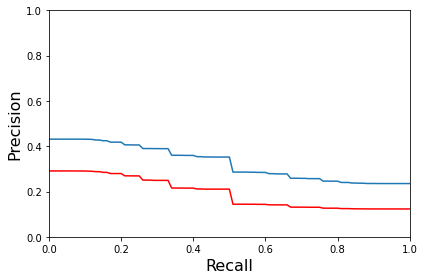

[0.43125546 0.43125546 0.43125546 0.43125546 0.43125546 0.43125546
 0.43125546 0.43125546 0.43125546 0.43125546 0.43100546 0.43086657
 0.43002873 0.4274329  0.4274329  0.4243544  0.4243544  0.41810349
 0.41810349 0.41805349 0.41805349 0.40611807 0.40611807 0.40571807
 0.40571807 0.40571807 0.38982548 0.38982548 0.38982548 0.3895556
 0.3895556  0.38934033 0.38934033 0.38934033 0.36005081 0.36005081
 0.36005081 0.35990637 0.35943882 0.35943882 0.35943882 0.35403433
 0.35395621 0.35273985 0.35273985 0.35232618 0.35227055 0.35227055
 0.35227055 0.35227055 0.35227055 0.28583611 0.28583611 0.28583611
 0.28583611 0.2857858  0.28518628 0.28518628 0.28447017 0.28435539
 0.28435539 0.27887231 0.27887231 0.27789099 0.27780382 0.27780382
 0.27780382 0.25856146 0.25856146 0.25856146 0.2581589  0.2581589
 0.25695028 0.25694448 0.25694448 0.25694448 0.24590797 0.24590797
 0.24565129 0.24565129 0.24565129 0.24022206 0.23999829 0.23999829
 0.23750512 0.23750512 0.236794   0.236794   0.23565768 0.235439

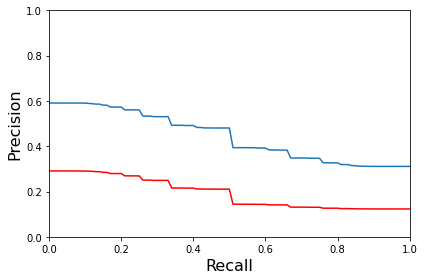

[0.59081421 0.59081421 0.59081421 0.59081421 0.59081421 0.59081421
 0.59081421 0.59081421 0.59081421 0.59081421 0.59038564 0.58911897
 0.58788564 0.58603088 0.58603088 0.58146782 0.58146782 0.57313955
 0.57313955 0.57313955 0.57313955 0.56062931 0.56062931 0.56062931
 0.56062931 0.56062931 0.53328925 0.53328925 0.53323369 0.53073798
 0.53073798 0.53071233 0.53071233 0.53071233 0.49251504 0.49251504
 0.49251504 0.49229555 0.49154361 0.49154361 0.49154361 0.48290622
 0.48290622 0.48098864 0.48098864 0.48056469 0.48055507 0.48055507
 0.48055507 0.48055507 0.48055507 0.39379116 0.39379116 0.39379116
 0.39379116 0.3937205  0.39346508 0.39346508 0.39196921 0.39196921
 0.39196921 0.38376427 0.38376427 0.3834074  0.38302462 0.38302462
 0.38302462 0.34813294 0.34813294 0.34813294 0.34809597 0.34809597
 0.34703014 0.3468834  0.3468834  0.3468834  0.32705787 0.32705787
 0.3265767  0.3265767  0.3265767  0.31905146 0.31898837 0.31898837
 0.31422244 0.31422244 0.31186885 0.31186885 0.31131957 0.3110

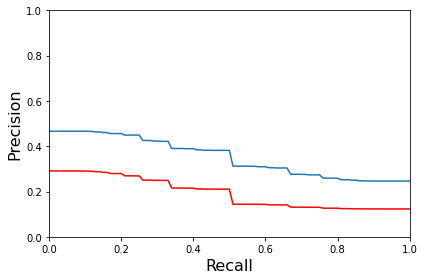

[0.46643584 0.46643584 0.46643584 0.46643584 0.46643584 0.46643584
 0.46643584 0.46643584 0.46643584 0.46643584 0.46643584 0.46603584
 0.46517473 0.46308663 0.46308663 0.46057371 0.46057371 0.45602784
 0.45602784 0.45602784 0.45602784 0.44922046 0.44922046 0.44921252
 0.44921252 0.44921252 0.42553876 0.42553876 0.42553876 0.42306384
 0.42306384 0.42174638 0.42174638 0.42174638 0.39001402 0.39001402
 0.39001402 0.39001402 0.38916541 0.38916541 0.38916541 0.38394785
 0.38394785 0.3822881  0.3822881  0.38199424 0.3818359  0.3818359
 0.3818359  0.3818359  0.3818359  0.31193486 0.31193486 0.31193486
 0.31193486 0.31193486 0.31144969 0.31144969 0.30941615 0.30941615
 0.30941615 0.30522745 0.30522745 0.30403167 0.30400944 0.30400944
 0.30400944 0.27607573 0.27607573 0.27607573 0.27574721 0.27574721
 0.27370262 0.27368675 0.27368675 0.27368675 0.2593399  0.2593399
 0.25884281 0.25884281 0.25884281 0.25202566 0.2519817  0.2519817
 0.25019399 0.25019399 0.24746965 0.24746965 0.24655354 0.2463644

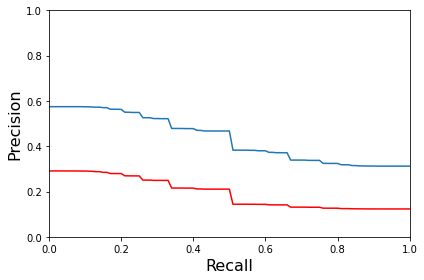

[0.57477638 0.57477638 0.57477638 0.57477638 0.57477638 0.57477638
 0.57477638 0.57477638 0.57477638 0.57477638 0.57420496 0.57420496
 0.57302785 0.57248023 0.57248023 0.57051356 0.57051356 0.56341982
 0.56341982 0.56329482 0.56296149 0.55030391 0.55030391 0.54924575
 0.54924575 0.54924575 0.52601999 0.52601999 0.52585927 0.52230815
 0.52230815 0.52177958 0.52177958 0.52177958 0.47855464 0.47855464
 0.47855464 0.47838183 0.47794943 0.4779161  0.4779161  0.4701251
 0.4701251  0.46752307 0.46752307 0.46743254 0.4673254  0.4673254
 0.4673254  0.4673254  0.4673254  0.382628   0.382628   0.38260736
 0.38260736 0.38259069 0.3819163  0.3819163  0.37997081 0.37997081
 0.37997081 0.37298425 0.37298156 0.3714776  0.37137335 0.37137335
 0.37137335 0.33885083 0.33885083 0.33885083 0.33876749 0.33876749
 0.33754088 0.33745211 0.33745211 0.33745211 0.3244326  0.3243385
 0.32405776 0.32405776 0.32405776 0.31823912 0.31821346 0.31821346
 0.31473452 0.31473452 0.31315161 0.31315161 0.3128207  0.3126319

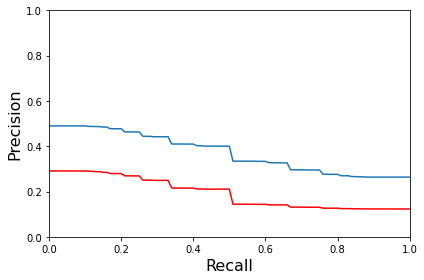

[0.48985606 0.48985606 0.48985606 0.48985606 0.48985606 0.48985606
 0.48985606 0.48985606 0.48985606 0.48985606 0.48985606 0.48784826
 0.48763398 0.48689762 0.48689762 0.48468095 0.48468095 0.47727169
 0.47727169 0.47727169 0.47727169 0.46333893 0.46333893 0.46331988
 0.46331988 0.46331988 0.44381101 0.44381101 0.44376556 0.44195059
 0.44195059 0.44193324 0.44193324 0.44193324 0.40982733 0.40982733
 0.40982733 0.40982733 0.40965117 0.40965117 0.40965117 0.40249341
 0.4024565  0.40063711 0.40063711 0.40048507 0.40028978 0.40028978
 0.40028978 0.40028978 0.40028978 0.33411466 0.33411466 0.33411466
 0.33411466 0.33411466 0.33394273 0.33394273 0.33320978 0.33320978
 0.33320978 0.32732172 0.32732172 0.32668714 0.3266097  0.3266097
 0.3266097  0.29593251 0.29593251 0.29593251 0.29561858 0.29561858
 0.29509736 0.29502398 0.29502398 0.29502398 0.27617527 0.27617527
 0.27578992 0.27578992 0.27578992 0.26955216 0.26952502 0.26952502
 0.26585519 0.26585519 0.26505217 0.26505217 0.26381707 0.26378

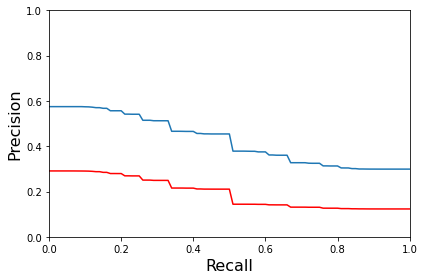

[0.57493679 0.57493679 0.57493679 0.57493679 0.57493679 0.57493679
 0.57493679 0.57493679 0.57493679 0.57493679 0.57427013 0.57387013
 0.57250218 0.57039449 0.57039449 0.5675421  0.5675421  0.55672902
 0.55672902 0.55670338 0.55670338 0.54180297 0.54180297 0.54134344
 0.54134344 0.54134344 0.51466795 0.51466795 0.51466795 0.51265777
 0.51265777 0.51255139 0.51255139 0.51255139 0.46607605 0.46607605
 0.46607605 0.4658655  0.46548912 0.46548912 0.46548912 0.4564705
 0.4564705  0.45465151 0.45465151 0.45427613 0.45427613 0.45427613
 0.45427613 0.45427613 0.45427613 0.37839669 0.37839669 0.37839669
 0.37839669 0.37805676 0.3777197  0.3777197  0.37503489 0.37503489
 0.37503489 0.36143113 0.36143113 0.36038923 0.36030223 0.36030223
 0.36030223 0.32727388 0.32727388 0.32727388 0.32721574 0.32721574
 0.32507853 0.32473135 0.32473135 0.32473135 0.31322706 0.31322706
 0.3128536  0.3128536  0.3128536  0.30422399 0.30405334 0.30405334
 0.30120653 0.30120653 0.29949334 0.29949334 0.29922529 0.29905

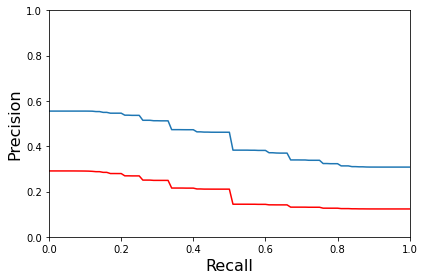

[0.55523944 0.55523944 0.55523944 0.55523944 0.55523944 0.55523944
 0.55523944 0.55523944 0.55523944 0.55523944 0.55523944 0.5551258
 0.55482818 0.55314    0.55314    0.54957629 0.54957629 0.54600622
 0.54600622 0.54600622 0.54600622 0.53719936 0.53719936 0.53642848
 0.53642848 0.53642848 0.51465587 0.51465587 0.51459093 0.51266
 0.51266    0.51220959 0.51220959 0.51220959 0.47328333 0.47328333
 0.47328333 0.4730712  0.4729427  0.4729427  0.4729427  0.46353976
 0.46353976 0.46243772 0.46243772 0.46190279 0.46183681 0.46183681
 0.46183681 0.46183681 0.46183681 0.38273061 0.38273061 0.38273061
 0.38273061 0.38268061 0.3823217  0.3823217  0.38160086 0.38158676
 0.38158676 0.37129764 0.37129764 0.37010273 0.36965855 0.36965855
 0.36965855 0.33949816 0.33949816 0.33949816 0.33930624 0.33930624
 0.33801404 0.33796316 0.33796316 0.33796316 0.32362453 0.32362453
 0.32291374 0.32291374 0.32291374 0.3132226  0.31319378 0.31319378
 0.30993786 0.30993786 0.30910473 0.30910473 0.30827746 0.30798927

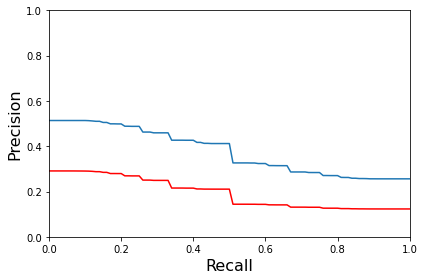

[0.51364903 0.51364903 0.51364903 0.51364903 0.51364903 0.51364903
 0.51364903 0.51364903 0.51364903 0.51364903 0.51364903 0.51301745
 0.51171486 0.51015502 0.51015502 0.50509662 0.50509662 0.49900995
 0.49900995 0.4985655  0.4985655  0.48844842 0.4883389  0.4878389
 0.4878389  0.4878389  0.46264404 0.46264404 0.46264404 0.45923748
 0.45923748 0.45921486 0.45921486 0.45921486 0.42668419 0.42668419
 0.42668419 0.42668419 0.42641538 0.42641538 0.42641538 0.41703502
 0.41703502 0.41279498 0.41279498 0.4119115  0.4118944  0.4118944
 0.4118944  0.4118944  0.4118944  0.32634022 0.32634022 0.32634022
 0.32634022 0.32634022 0.32595763 0.32595763 0.32361756 0.32361756
 0.32361756 0.31455663 0.31455663 0.31426118 0.31419331 0.31413534
 0.31413534 0.28635287 0.28635287 0.28635287 0.28634712 0.28634712
 0.28395398 0.28385839 0.28385839 0.28385839 0.27063651 0.27063651
 0.27038361 0.27032608 0.27032608 0.26243405 0.26211929 0.26211929
 0.25869225 0.25869225 0.25730442 0.25730442 0.25700758 0.256152

In [ ]:
history = model.fit(lstm_dataset, epochs=100, steps_per_epoch=1000, callbacks=[cp_callback, prc_callback])

300/300 [==============================] - 25s 82ms/step


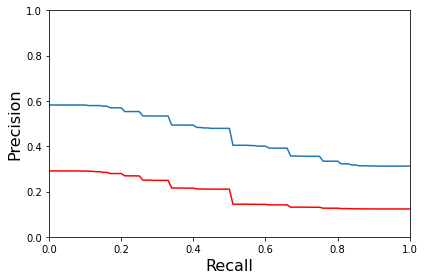

[0.58216958 0.58216958 0.58216958 0.58216958 0.58216958 0.58216958
 0.58216958 0.58216958 0.58216958 0.58216958 0.5819844  0.57960345
 0.57960345 0.57960345 0.57960345 0.57715315 0.57715315 0.56976616
 0.56976616 0.56976616 0.56976616 0.55321839 0.55321839 0.55321839
 0.55321839 0.55321839 0.5338023  0.5338023  0.5338023  0.53360028
 0.53360028 0.53346139 0.53346139 0.53346139 0.49355967 0.49355967
 0.49355967 0.49325465 0.49314354 0.49314354 0.49314354 0.48290111
 0.48290111 0.48078567 0.48078567 0.47896749 0.47896749 0.47896749
 0.47896749 0.47896749 0.47896749 0.40428616 0.40428616 0.40428616
 0.40428616 0.40417635 0.40291646 0.40291646 0.40034701 0.40034701
 0.40034701 0.39178289 0.39178289 0.39157374 0.39157374 0.39157374
 0.39157374 0.35654933 0.35654933 0.35654933 0.35602564 0.35602564
 0.35547118 0.35543899 0.35543899 0.35543899 0.33404246 0.33404246
 0.33404246 0.33404246 0.33404246 0.32220925 0.32218487 0.32218487
 0.31711261 0.31711261 0.31372856 0.31372856 0.31367508 0.3128

<Figure size 432x288 with 0 Axes>

In [22]:
generate_prc(300)

In [23]:
len(label_dict_keys)

661

In [24]:
print(label_dict_keys)

{'G01H', 'C10H', 'D06C', 'D03J', 'A41C', 'H02G', 'F41B', 'B04B', 'B42D', 'B63H', 'B33Y', 'B23F', 'B21K', 'C10J', 'G01L', 'A61P', 'F26B', 'A01H', 'C06B', 'C05B', 'C01D', 'C13K', 'H01F', 'C12Q', 'H01B', 'B04C', 'A24D', 'H01R', 'G21F', 'F02P', 'B23K', 'B82Y', 'G05G', 'A21C', 'F41A', 'A01F', 'D04B', 'A47K', 'F16N', 'F03D', 'E05F', 'D05B', 'B27B', 'B65F', 'A01L', 'D05C', 'F21L', 'C09F', 'A47G', 'B02C', 'B25J', 'B64G', 'D06F', 'A23J', 'B60H', 'C08B', 'A01C', 'H04H', 'F24H', 'G21C', 'G01N', 'A23F', 'C12J', 'A21D', 'F02G', 'G04B', 'G09F', 'F16P', 'B27F', 'B64B', 'B67B', 'B60M', 'A23G', 'H01C', 'B07C', 'C07G', 'B65C', 'C22B', 'B27K', 'F24S', 'B60J', 'F22D', 'B27D', 'A41G', 'B05C', 'G04G', 'G16H', 'F23Q', 'A23L', 'A21B', 'G21G', 'F16D', 'C21D', 'B41C', 'A24B', 'B66D', 'G04C', 'C23F', 'D06J', 'A23N', 'F16G', 'C12M', 'B43M', 'A47F', 'C12Y', 'G05D', 'A63H', 'F16F', 'B65B', 'F41C', 'B21H', 'E21F', 'F04D', 'D21G', 'G03G', 'B27C', 'C07K', 'Y02C', 'C23C', 'Y10T', 'C12P', 'A01D', 'B63B', 'A41H', 'F22G',